## Overview

This notebook contains all of the modelling functions. The corresponding results and metrics are also produced in this notebook. The models explored are: random forest and neural network. All results are saved to wandb. 

Note: a wandb login is required to be compatible with this notebook

## Setup

In [1]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import wandb
from fastbook import *

/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
# login to wandb so we can track runs
wandb.login()

wandb: Currently logged in as: hamish-cam. Use `wandb login --relogin` to force relogin


True

## Train/test Dataset Splits

We choose Burwell Fen as the test set. Burwell Fen provides spatial seperation and only contatins modern data points. The training dataset contains the rest of the data (both historical and modern data points)

In [3]:
# load in the complete preprocessed dataset
df = pd.read_csv('depth_dataset.csv', index_col='system:index')

# get the feature names from the column headings 
feature_names = [i for i in df.columns]
feature_names.remove('depth')
feature_names.remove('partner')
feature_names.remove('location')

# use Burwell Fen as the test set
test_df = df.loc[df['location'] == 'Burwell Fen']
df = df.loc[df['location'] != 'Burwell Fen']

# some models need explicit datasets
x_train = df.drop(['depth','partner','location'], axis=1)
y_train = df['depth']
x_test = test_df.drop(['depth','partner','location'], axis=1)
y_test = test_df['depth']

## Feature Selection

We select only the features that we have shown to be important for making predictions and that do not have circular dependence issues. To find important features, we first start with all features and then reduce the number gradually. The features selected here are the end result of this process

In [4]:
# select the features we want to include 
selected_features = ['date', 'Landcover', 'Elevation', 'Blue', 'NIR', 'Landcover_conf']

## Setup wandb Tracking

In [5]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Depth Mapping",
    name="Burwell Fen, 6 preds, tree depth=5",
    
    # track hyperparameters
    config={
        "features included": selected_features
    }
)

## Random Forest

In [6]:
# instantiate the random forest regressor object
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 1, oob_score=True, max_depth=5)
 
# fit the random forest to the selected training predictor and target data
rf_model.fit(x_train[selected_features], y_train) 

RandomForestRegressor(max_depth=5, oob_score=True, random_state=1)

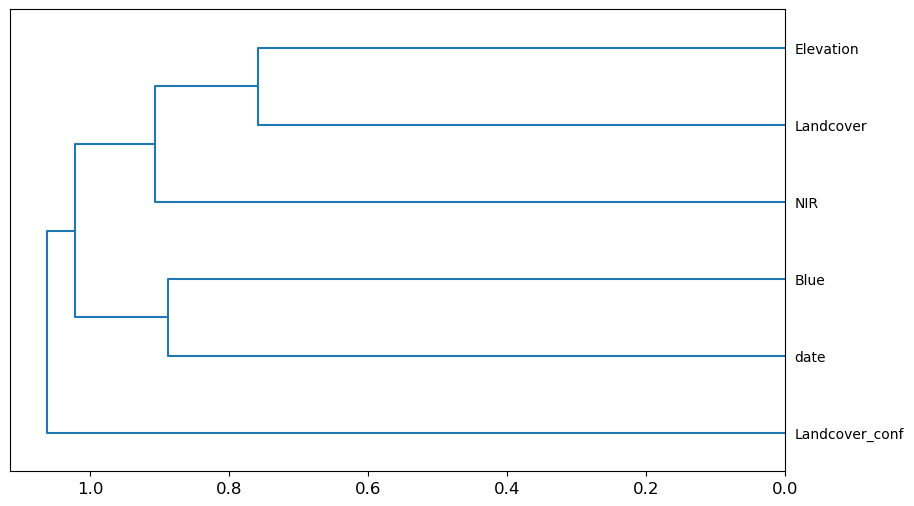

In [7]:
# function to create a dendrogram using rank correlation
def cluster_columns(df, figsize=(10,6), font_size=11):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
    return fig

# create a diagram showing how correlated the selected predictors are
rank_corr = cluster_columns(x_train[selected_features], font_size=10);

# log this in wandb
wandb.log({"Rank Correlation": wandb.Image(rank_corr)})

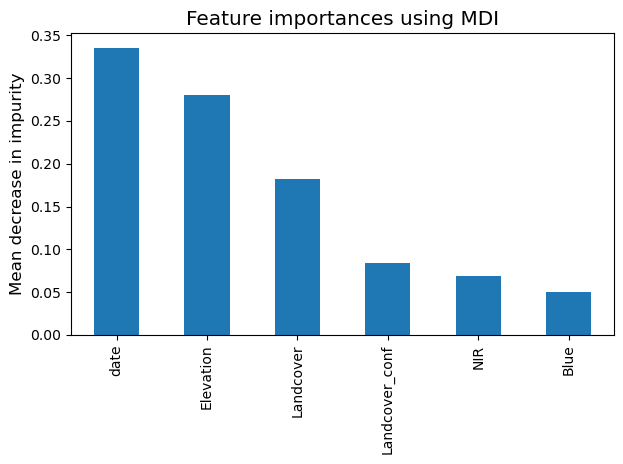

In [8]:
# study the feature importances output by the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=selected_features)
forest_importances = forest_importances.sort_values().iloc[::-1]

# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.tick_params(axis='both', which='major', labelsize=10)
fig.tight_layout()

# save the same plot in wandb for later reference 
wandb.log({"Feature Importance": wandb.Image(fig)})

In [9]:
# make some predictions using our trained model
y_pred_train = rf_model.predict(x_train[selected_features])
y_pred_test = rf_model.predict(x_test[selected_features])

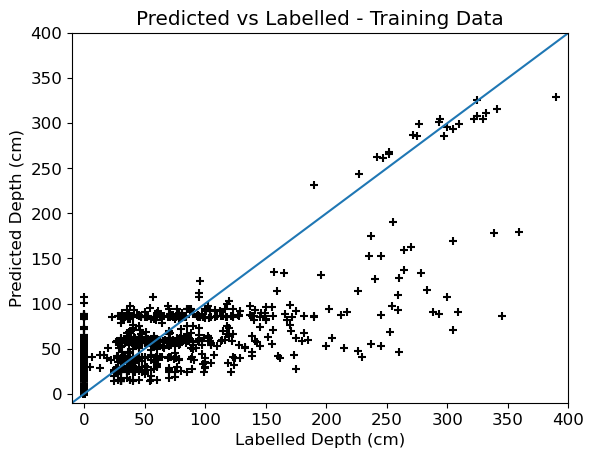

In [10]:
# plot a scatter plot of the predictions using the training set (qualitative performance metric)
plt.scatter(y_train, y_pred_train, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

# save the same plot in wandb for later reference 
wandb.log({"Training Predictions": wandb.Image(ax)})

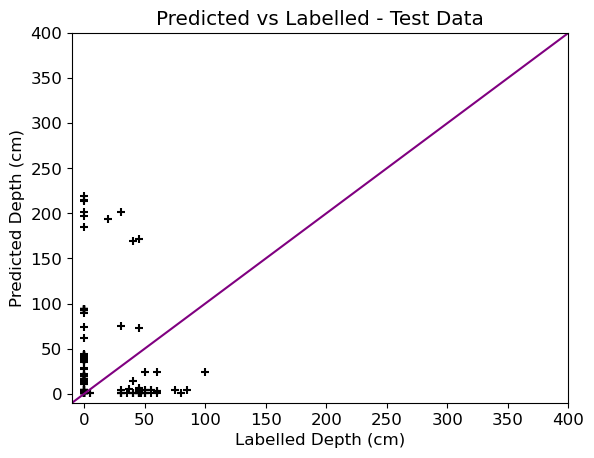

In [11]:
# plot for the test set also 
plt.scatter(y_test, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

# save the same plot in wandb for later reference 
wandb.log({"Test Predictions": wandb.Image(ax)})

In [12]:
# Now calculate some metrics to track quantitive performance 
# OOB error used to see performance on unseen data - limits overfitting
print("Out of bag error:", rf_model.oob_score_, "\n")

# R2 score and RMSE for training set
R_squared_train = r2_score(y_train, y_pred_train)
RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("R Squared (training):", R_squared_train)
print("RMSE (training):", RMSE_train, "\n")

# R2 score and RMSE for test set (only contains new data!)
R_squared_test = r2_score(y_test, y_pred_test)
RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("R Squared (test):", R_squared_test)
print("RMSE (test):", RMSE_test)

# save metrics to wandb for this experiment also
wandb.log({"OOB error": rf_model.oob_score_, 
           "R2 (training)": R_squared_train,
           "RMSE (training)": RMSE_train,
           "R2 (test)": R_squared_test,
           "RMSE (test)": RMSE_test})

Out of bag error: 0.4767658082850462 

R Squared (training): 0.583866576695566
RMSE (training): 44.82088320944566 

R Squared (test): -6.570703460738177
RMSE (test): 63.854198707243015


## Neural Network

In [13]:
# Split the whole dataset into three this time: training, validation and testing
df = pd.read_csv('depth_dataset.csv', index_col='system:index')

# take a specific location as the test set
test_df = df.loc[df['location'] == 'Burwell Fen']
df = df.loc[df['location'] != 'Burwell Fen']
df.reset_index()

# split randomly into training and validation 
splits_train_val = RandomSplitter(valid_pct=0.2, seed=10)(df)

# required for plotting
y_train = df.iloc[splits_train_val[0],:]['depth']
y_val = df.iloc[splits_train_val[1],:]['depth']
y_test = test_df['depth']


In [14]:
# instantiate the dataloader object (need to specify categorical and continuous predictors this time)
dls = TabularPandas(
    df, 
    splits=splits_train_val,
    procs = [Categorify, Normalize],
    cat_names=["Landcover"],
    cont_names=['Blue', 'Elevation', 'NIR', 'Landcover_conf', 'date'],
    y_names="depth", 
    y_block = RegressionBlock(),
).dataloaders(path=".")

In [15]:
# setup the architecture we want for the neural network. We constrain the model to produce predictions >0 only
learn = tabular_learner(dls, metrics=[rmse, R2Score()], layers=[20,10])
learn.model.layers.add_module("ReLU", nn.ReLU(inplace=True))

In [16]:
# fit the model to the training examples
learn.fit(25, lr=0.1)
learn.fit(10, lr=0.01)

epoch,train_loss,valid_loss,_rmse,r2_score,time
0,6112.810059,5253.282715,72.479530,-0.092053,00:00
1,5245.145020,4660.924316,68.270966,0.031086,00:00
2,4709.300781,3001.620117,54.787041,0.376023,00:00
3,4181.602539,2849.497070,53.380680,0.407646,00:00
4,3813.699707,2708.616211,52.044369,0.436932,00:00
5,3500.628662,2920.028076,54.037285,0.392984,00:00
6,3311.777832,2850.732910,53.392254,0.407389,00:00
7,3079.627441,3779.348877,61.476406,0.214348,00:00
8,3041.757324,2630.897949,51.292278,0.453088,00:00
9,2982.651123,2526.563232,50.264935,0.474778,00:00


epoch,train_loss,valid_loss,_rmse,r2_score,time
0,2460.610596,2435.281738,49.348572,0.493753,00:00
1,2496.945557,2394.863525,48.937340,0.502155,00:00
2,2499.013428,2378.777344,48.772709,0.505499,00:00
3,2454.931885,2392.201172,48.910133,0.502709,00:00
4,2435.075195,2409.140869,49.082996,0.499187,00:00
5,2349.697754,2379.496826,48.780087,0.505350,00:00
6,2354.480469,2400.160156,48.991428,0.501054,00:00
7,2374.796143,2370.858398,48.691463,0.507146,00:00
8,2356.982910,2389.642822,48.883972,0.503241,00:00
9,2333.758545,2364.923340,48.630482,0.508379,00:00


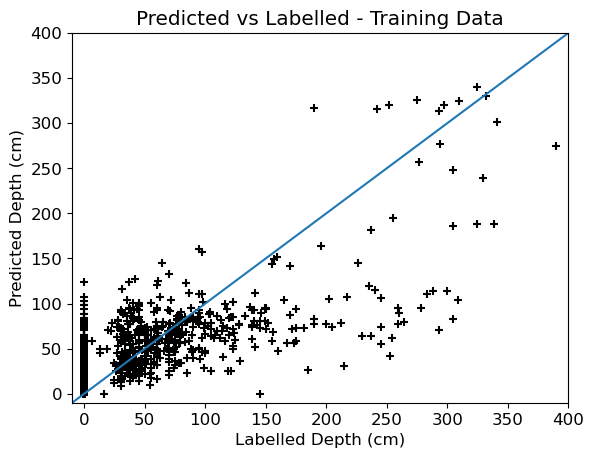

In [17]:
# Use the trained model to get predictions for training dataset
preds_train,_ = learn.get_preds(dl=dls.train)

# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_train, preds_train, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

# save the same plot in wandb for later reference 
wandb.log({"NN Train Performance": wandb.Image(ax)})

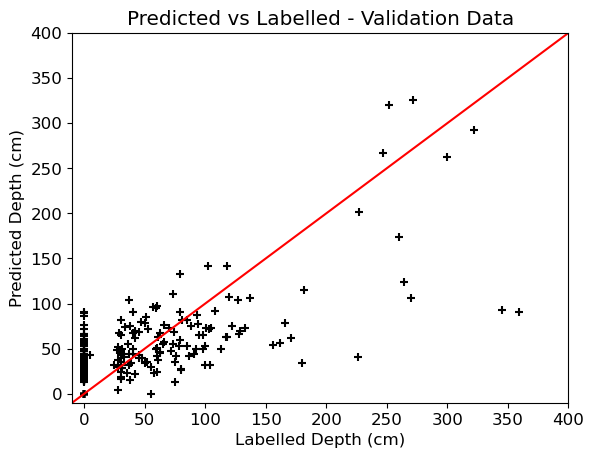

In [18]:
# Use the trained model to get predictions for training dataset
preds_val,_ = learn.get_preds(dl=dls.valid)

# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_val, preds_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Validation Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='red');

# save the same plot in wandb for later reference 
wandb.log({"NN Validation Performance": wandb.Image(ax)})

In [19]:
# make sure to apply the same transforms to the test data
tst_dl = learn.dls.test_dl(test_df)
preds,_ = learn.get_preds(dl=tst_dl)

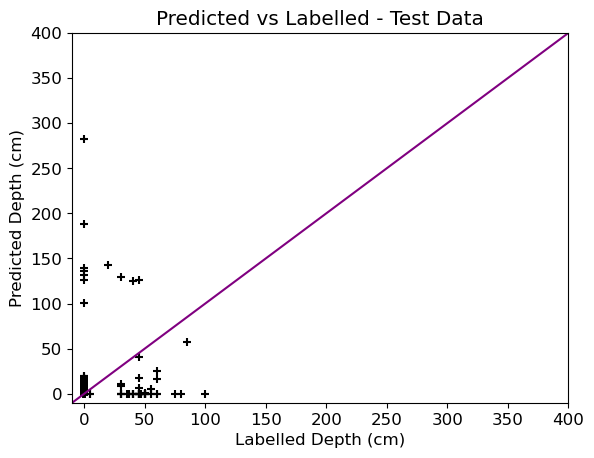

In [20]:
# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_test, preds, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

# save the same plot in wandb for later reference 
wandb.log({"NN Test Performance": wandb.Image(ax)})

In [21]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_train, preds_train)
print("R Squared (Train):", R_squared)

RMSE = mean_squared_error(y_train, preds_train, squared=False)
print("RMSE (Train):", RMSE)

# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_val, preds_val)
print("R Squared (Validation):", R_squared)

RMSE = mean_squared_error(y_val, preds_val, squared=False)
print("RMSE (Validation):", RMSE)

# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, preds)
print("R Squared (Test):", R_squared)

RMSE = mean_squared_error(y_test, preds, squared=False)
print("RMSE: (Test)", RMSE)

R Squared (Train): 0.5378933680267111
RMSE (Train): 47.23690389805899
R Squared (Validation): 0.5083793001790112
RMSE (Validation): 48.63047730365856
R Squared (Test): -3.142622553595591
RMSE: (Test) 47.23446756527994


In [22]:
# Finish the wandb run, necessary in notebooks
wandb.finish()

OOB error,▁
R2 (test),▁
R2 (training),▁
RMSE (test),▁
RMSE (training),▁
OOB error,0.47677
R2 (test),-6.5707
R2 (training),0.58387
RMSE (test),63.8542
RMSE (training),44.82088
